<a href="https://colab.research.google.com/github/s25337/plant-disease-ai/blob/main/plant_illness_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import os
import pandas as pd

dataset_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
train_dir = os.path.join(dataset_path, "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")

dataset_path_train = os.path.join(train_dir, "train")
dataset_path_valid = os.path.join(train_dir, "valid")

def create_dataset_csv(dataset_dir, output_csv):
    image_paths = []
    labels = []

    for subfolder in os.listdir(dataset_dir):
        subfolder_path = os.path.join(dataset_dir, subfolder)

        if os.path.isdir(subfolder_path):
            label = 'healthy' if subfolder.endswith('healthy') else 'not_healthy'

            for file in os.listdir(subfolder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    image_path = os.path.join(subfolder_path, file)

                    image_paths.append(image_path)
                    labels.append(label)

    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    data.to_csv(output_csv, index=False)
    print(f"Dataset CSV has been created at {output_csv}.")


create_dataset_csv(dataset_path_train, 'train_labels.csv')
create_dataset_csv(dataset_path_valid, 'valid_labels.csv')

100%|██████████| 2.70G/2.70G [01:21<00:00, 35.6MB/s]

Extracting files...


Dataset CSV has been created at train_labels.csv.
Dataset CSV has been created at valid_labels.csv.


In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [4]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]
        img = Image.open(img_path).convert("RGB")

        # Convert label to integer (1 = healthy, 0 = not_healthy)
        label = 1 if label == 'healthy' else 0

        if self.transform:
            img = self.transform(img)

        return img, label

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = PlantDiseaseDataset(csv_file='train_labels.csv', transform=transform)
valid_dataset = PlantDiseaseDataset(csv_file='valid_labels.csv', transform=transform)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [6]:
def train_model(model, train_loader, valid_loader, num_epochs=10, lr=0.001, device='cuda', model_path="content/default.pth"):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
    model_path = model_path
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    return model

In [7]:
class RainforestNN(nn.Module):
    def __init__(self):
        super(RainforestNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.classifier(x)
        return x

In [8]:
os.makedirs(os.path.dirname("content/rain_forest.pth"), exist_ok=True)

In [9]:
model_rain_forest = RainforestNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_rain_forest.to(device)
rain_forest_trained = train_model(model_rain_forest, train_loader, valid_loader, num_epochs=10, lr=0.001, device='cuda', model_path="content/rain_forest.pth")

Epoch [1/10], Loss: 0.1259, Accuracy: 95.83%
Validation Accuracy: 98.83%
Epoch [2/10], Loss: 0.0426, Accuracy: 99.10%
Validation Accuracy: 99.33%
Epoch [3/10], Loss: 0.0502, Accuracy: 98.57%
Validation Accuracy: 99.50%
Epoch [4/10], Loss: 0.0276, Accuracy: 99.43%
Validation Accuracy: 99.67%
Epoch [5/10], Loss: 0.0276, Accuracy: 99.59%
Validation Accuracy: 99.67%
Epoch [6/10], Loss: 0.0525, Accuracy: 99.14%
Validation Accuracy: 98.83%
Epoch [7/10], Loss: 0.0284, Accuracy: 99.63%
Validation Accuracy: 99.50%
Epoch [8/10], Loss: 0.0305, Accuracy: 99.10%
Validation Accuracy: 99.33%
Epoch [9/10], Loss: 0.0437, Accuracy: 98.98%
Validation Accuracy: 96.99%
Epoch [10/10], Loss: 0.0189, Accuracy: 99.51%
Validation Accuracy: 99.83%
Model saved to content/rain_forest.pth


In [10]:
os.makedirs(os.path.dirname("content/cnn.pth"), exist_ok=True)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model_cnn = SimpleCNN()
model = model_cnn.to(device)
rain_forest_trained = train_model(model_cnn, train_loader, valid_loader, num_epochs=10, lr=0.001, device='cuda', model_path="content/cnn.pth")

Epoch [1/10], Loss: 0.1404, Accuracy: 94.73%
Validation Accuracy: 99.00%
Epoch [2/10], Loss: 0.0168, Accuracy: 99.55%
Validation Accuracy: 99.50%
Epoch [3/10], Loss: 0.0140, Accuracy: 99.51%
Validation Accuracy: 99.67%
Epoch [4/10], Loss: 0.0076, Accuracy: 99.84%
Validation Accuracy: 99.67%
Epoch [5/10], Loss: 0.0028, Accuracy: 99.88%
Validation Accuracy: 99.67%
Epoch [6/10], Loss: 0.0004, Accuracy: 100.00%
Validation Accuracy: 99.50%
Epoch [7/10], Loss: 0.0004, Accuracy: 100.00%
Validation Accuracy: 99.67%
Epoch [8/10], Loss: 0.0001, Accuracy: 100.00%
Validation Accuracy: 99.67%
Epoch [9/10], Loss: 0.0001, Accuracy: 100.00%
Validation Accuracy: 99.67%
Epoch [10/10], Loss: 0.0000, Accuracy: 100.00%
Validation Accuracy: 99.67%
Model saved to content/cnn.pth


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [14]:
loaded_model_rain_forest = RainforestNN()  # Create a new instance of the model
loaded_model_rain_forest.load_state_dict(torch.load("content/rain_forest.pth"))  # Load the saved weights
loaded_model_rain_forest = loaded_model_rain_forest.to(device)  # Move the loaded model to the device
loaded_model_rain_forest.eval()  # Set the model to evaluation mode
loaded_model_cnn = SimpleCNN()  # Create a new instance of the model
loaded_model_cnn.load_state_dict(torch.load("content/cnn.pth"))  # Load the saved weights
loaded_model_cnn = loaded_model_cnn.to(device)  # Move the loaded model to the device
loaded_model_cnn.eval()  # Set the model to evaluation mode
test_loader = valid_loader

<ipython-input-14-f434b103d4cb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_rain_forest.load_state_dict(torch.load("content/rain_forest.pth"))  # Load the 

In [15]:
y_pred_rain_forest = []
y_true_rain_forest = []
for images, labels in test_loader:
  images = images.to(device)  # Move images to the same device as the model
  labels = labels.to(device)
  outputs = loaded_model_rain_forest(images)
  _, predicted = torch.max(outputs, 1)
  y_pred_rain_forest.extend(predicted.tolist())
  y_true_rain_forest.extend(labels.tolist())

# Uzyskaj predykcje z model2
y_pred_cnn = []
y_true_cnn = []
for images, labels in test_loader:
  images = images.to(device)  # Move images to the same device as the model
  labels = labels.to(device)
  outputs = loaded_model_cnn(images)
  _, predicted = torch.max(outputs, 1)
  y_pred_cnn.extend(predicted.tolist())
  y_true_cnn.extend(labels.tolist())

In [16]:
cm1 = confusion_matrix(y_true_rain_forest, y_pred_rain_forest)

# Macierz błędów dla model2
cm2 = confusion_matrix(y_true_cnn, y_pred_cnn)

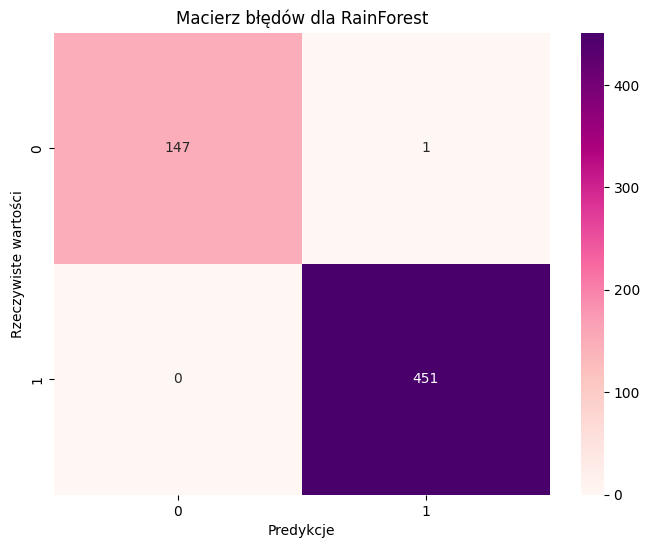

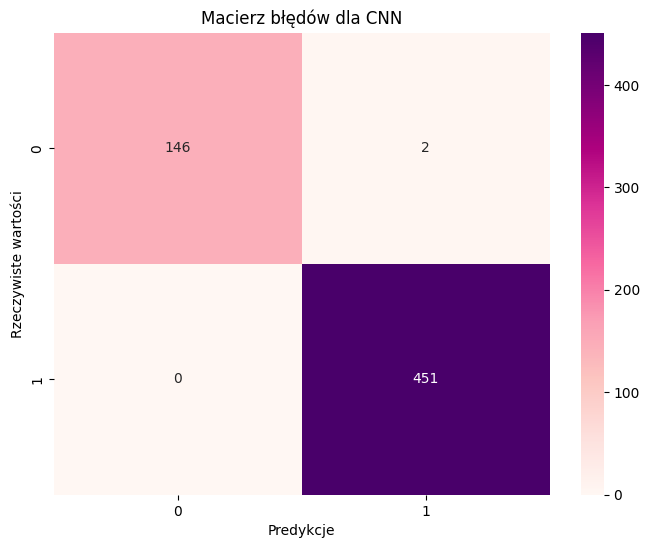

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="RdPu")
plt.title("Macierz błędów dla RainForest")
plt.xlabel("Predykcje")
plt.ylabel("Rzeczywiste wartości")
plt.show()

# Wyświetl macierz błędów dla model2
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="RdPu")
plt.title("Macierz błędów dla CNN")
plt.xlabel("Predykcje")
plt.ylabel("Rzeczywiste wartości")
plt.show()